In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages --------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dset_idx <- 3
# hub_con_thresh <- 0.25
hub_con_thresh <- 0.0

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
cancer_name <- c("cervical cancer", "none", "endometrial cancer")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [4]:
matrisome_df <- rutils::load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category) %>%
    dplyr::rename(geneID = gene_symbol)
deseq_df <- read_tsv(paste0(dirs$analysis_dir, "/deg/", unified_dsets[dset_idx], "_DESeq_results.tsv")) %>%
    rename(base_mean = baseMean, lfc = log2FoldChange) %>%
    mutate(change_dir = ifelse(lfc > 0, "up", "down")) %>%
    select(geneID, change_dir, base_mean, lfc, qval)
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
figo_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
survival_umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_survival_umsmg_list.txt"))
figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))


-- Column specification --------------------------------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)



-- Column specification --------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)




In [5]:
pathology_df <- read_tsv(paste0(dirs$data_dir, "/THPA_v20_1_staining/pathology.tsv")) %>%
    rename_all(tolower) %>%
    rename_with(~ gsub(" - ", "_", .x, fixed = TRUE)) %>%
    rename_with(~ gsub(" ", "_", .x, fixed = TRUE)) %>%
    rename(geneID = gene_name) %>%
    select(geneID, cancer, high, medium, low, not_detected) %>%
    filter(cancer %in% cancer_name[dset_idx]) %>%
    filter(rowSums(is.na(.[,3:6])) == 0) %>%
    dplyr::mutate(detected_count = rowSums(.[c("high", "medium", "low")]))


-- Column specification --------------------------------------------------------------------------------------------------------------------------
cols(
  Gene = col_character(),
  `Gene name` = col_character(),
  Cancer = col_character(),
  High = col_double(),
  Medium = col_double(),
  Low = col_double(),
  `Not detected` = col_double(),
  `prognostic - favorable` = col_double(),
  `unprognostic - favorable` = col_double(),
  `prognostic - unfavorable` = col_double(),
  `unprognostic - unfavorable` = col_double()
)




In [6]:
joined_mat_stats_df <- matrisome_df %>%
    inner_join(pathology_df, by = "geneID")

In [7]:
demg_stats_df <- deseq_df %>%
    filter(geneID %in% demg_list) %>%
    arrange(geneID)
joined_demg_stats_df <- demg_stats_df %>%
    inner_join(pathology_df, by = "geneID") %>%
    arrange(change_dir)

In [8]:
figo_umsmg_demg_stats_df <- deseq_df %>%
    filter(geneID %in% intersect(figo_umsmg_list, demg_list)) %>%
    arrange(geneID)
joined_figo_umsmg_demg_stats_df <- figo_umsmg_demg_stats_df %>% 
    inner_join(pathology_df, by = "geneID") %>%
    arrange(change_dir)

In [9]:
figo_nsmg_demg_stats_df <- deseq_df %>%
    filter(geneID %in% intersect(figo_nsmg_list, demg_list)) %>%
    arrange(geneID)
joined_figo_nsmg_demg_stats_df <- figo_nsmg_demg_stats_df %>% 
    inner_join(pathology_df, by = "geneID") %>%
    arrange(change_dir)

In [10]:
survival_umsmg_demg_stats_df <- deseq_df %>%
    filter(geneID %in% intersect(survival_umsmg_list, demg_list)) %>%
    arrange(geneID)
joined_survival_umsmg_demg_stats_df <- survival_umsmg_demg_stats_df %>% 
    inner_join(pathology_df, by = "geneID") %>%
    arrange(change_dir)

# Likelihood of a group of genes showing up in staining

In [11]:
sum(joined_mat_stats_df$detected_count > 0) / nrow(joined_mat_stats_df)
sum(joined_demg_stats_df$detected_count > 0) / nrow(joined_demg_stats_df)
sum(joined_figo_umsmg_demg_stats_df$detected_count > 0) / nrow(joined_figo_umsmg_demg_stats_df)
sum(joined_figo_nsmg_demg_stats_df$detected_count > 0) / nrow(joined_figo_nsmg_demg_stats_df)
sum(joined_survival_umsmg_demg_stats_df$detected_count > 0) / nrow(joined_survival_umsmg_demg_stats_df)

[1] 0.6666667

[1] 0.7186147

[1] 0.6875

[1] 0.8235294

[1] 0.65

In [12]:
group_detections_df <- tibble(
    group = c(
        rep("mat", nrow(joined_mat_stats_df)),
        rep("demg", nrow(joined_demg_stats_df)),
        rep("figo_umsmg_demg", nrow(joined_figo_umsmg_demg_stats_df)),
        rep("figo_nsmg_demg", nrow(joined_figo_nsmg_demg_stats_df)),
        rep("survival_umsmg_demg", nrow(joined_survival_umsmg_demg_stats_df))
    ),
    detected_count = c(
        joined_mat_stats_df$detected_count,
        joined_demg_stats_df$detected_count,
        joined_figo_umsmg_demg_stats_df$detected_count,
        joined_figo_nsmg_demg_stats_df$detected_count,
        joined_survival_umsmg_demg_stats_df$detected_count
    )
) %>%
    dplyr::mutate(group_f = factor(group))

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


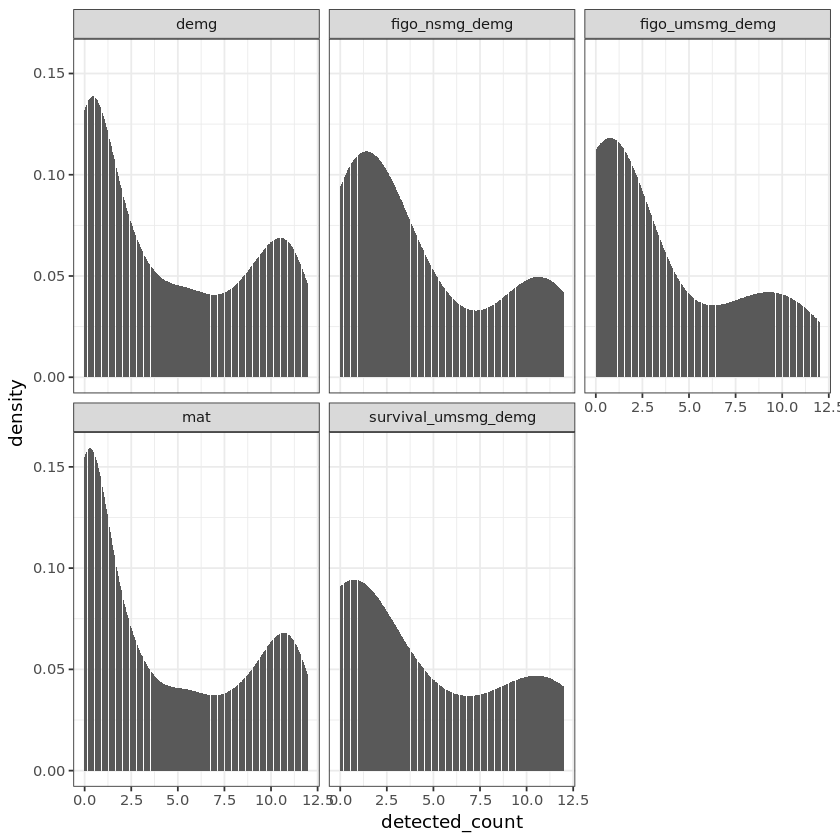

In [13]:
ggplot(data = group_detections_df) +
#     geom_violin(aes(x = factor(group), y = detected_count)) +
    geom_histogram(aes(x = detected_count), stat = "density") +
    facet_wrap(~ group_f) +
    theme_bw()

In [16]:
x <- group_detections_df %>% 
    dplyr::filter(group == "mat") %>%
    dplyr::pull(detected_count)
y <- group_detections_df %>%
    dplyr::filter(group == "survival_umsmg_demg") %>%
    dplyr::pull(detected_count)
ks.test(x, y)

Warning message in ks.test(x, y):
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  x and y
D = 0.074297, p-value = 0.9999
alternative hypothesis: two-sided
